# Exploratory Data Analysis - Daily Item Sales

This notebook performs comprehensive exploratory data analysis on the daily item sales data, including:

- Trends analysis
- Seasonality patterns
- Stationarity assessment
- Cyclical patterns
- Outlier detection
- Time series visualization
- Seasonal subseries plots
- Autocorrelation analysis (ACF/PACF)

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [3]:
# Load the daily item sales data
base_path = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
data_path = os.path.join(base_path, 'data', 'processed', 'daily_item_sales.csv')

# Read the data
df = pd.read_csv(data_path)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

print('Data Overview:')
print(f'Shape: {df.shape}')
print(f'Date range: {df["Date"].min()} to {df["Date"].max()}')
print(f'Unique items: {df["Item"].nunique()}')
print(f'Total sales records: {len(df)}')

print('\nFirst few rows:')
print(df.head())

print('\nData summary:')
print(df.describe())

Data Overview:
Shape: (31563, 3)
Date range: 2022-01-01 00:00:00 to 2025-09-25 00:00:00
Unique items: 78
Total sales records: 31563

First few rows:
        Date           Item  Quantity_Sold
0 2022-01-01      Ajeng Hot            3.0
1 2022-01-01  Waffle Matcha            1.0
2 2022-01-01   Vietnam Drip            2.0
3 2022-01-01    Tubruk Susu            2.0
4 2022-01-01         Tubruk            2.0

Data summary:
                                Date  Quantity_Sold
count                          31563   31563.000000
mean   2024-01-27 17:01:46.415739904       1.820581
min              2022-01-01 00:00:00       1.000000
25%              2023-02-26 00:00:00       1.000000
50%              2024-02-29 00:00:00       1.000000
75%              2025-01-15 00:00:00       2.000000
max              2025-09-25 00:00:00      60.000000
std                              NaN       1.452160


## 1. Basic Data Exploration

In [4]:
# Basic statistics
print('Top 10 best-selling items:')
top_items = df.groupby('Item')['Quantity_Sold'].sum().sort_values(ascending=False).head(10)
print(top_items)

print('\nDaily sales statistics:')
daily_totals = df.groupby('Date')['Quantity_Sold'].sum()
print(daily_totals.describe())

# Check for missing values
print('\nMissing values:')
print(df.isnull().sum())

# Check data types
print('\nData types:')
print(df.dtypes)

Top 10 best-selling items:
Item
Kopi Susu Ice     4185.0
Tubruk            2799.0
Lychee Tea Ice    2787.0
Basreng           2172.0
Kentang Goreng    2093.0
Vietnam Drip      2013.0
Tubruk Susu       1770.0
Kinasih           1752.0
Mie Goreng        1429.0
Lemon Ice         1389.0
Name: Quantity_Sold, dtype: float64

Daily sales statistics:
count    1357.000000
mean       42.345615
std        22.215838
min         5.000000
25%        28.000000
50%        38.000000
75%        53.000000
max       169.000000
Name: Quantity_Sold, dtype: float64

Missing values:
Date             0
Item             0
Quantity_Sold    0
dtype: int64

Data types:
Date             datetime64[ns]
Item                     object
Quantity_Sold           float64
dtype: object


## 2. Time Series Plot

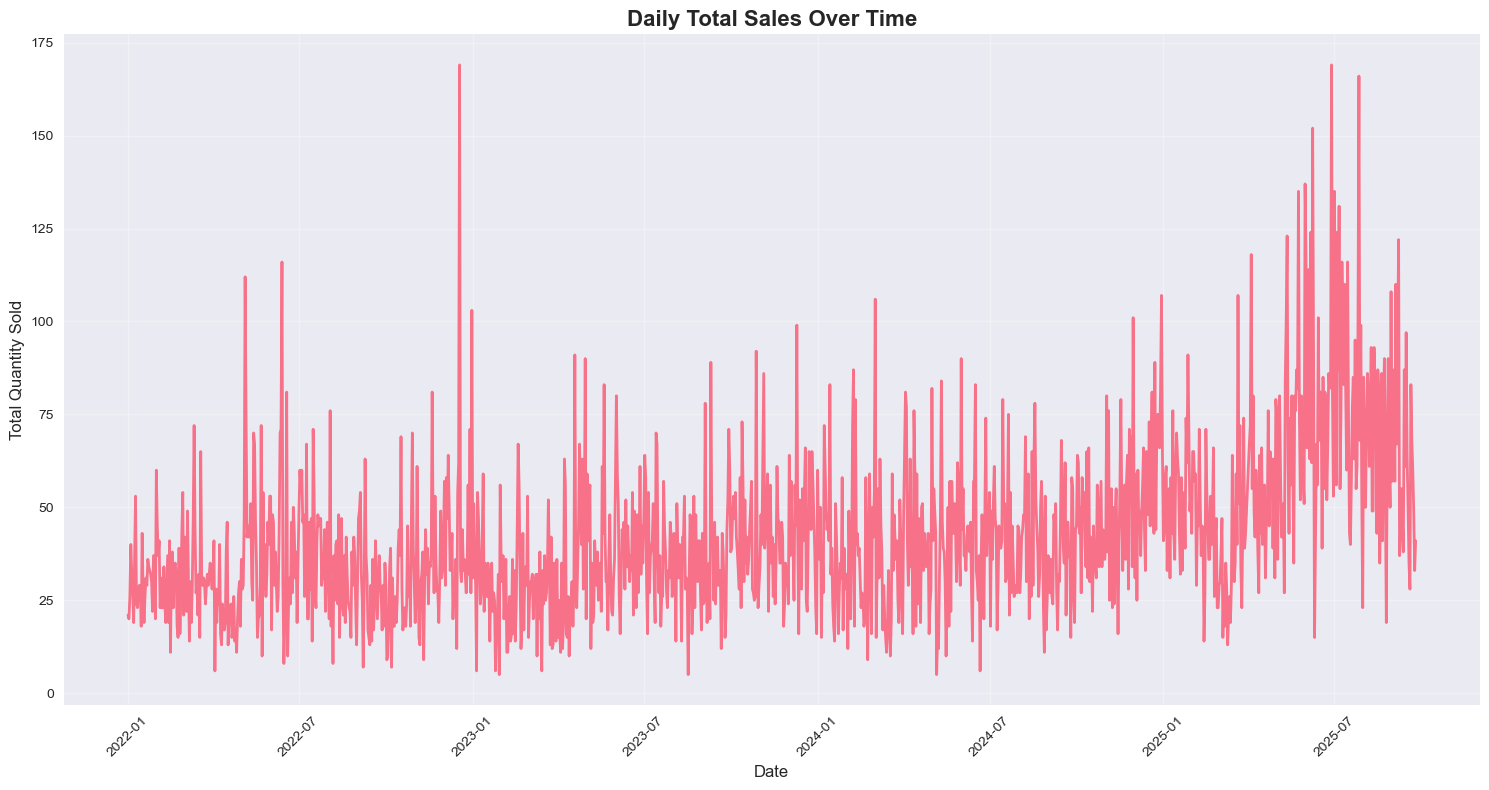

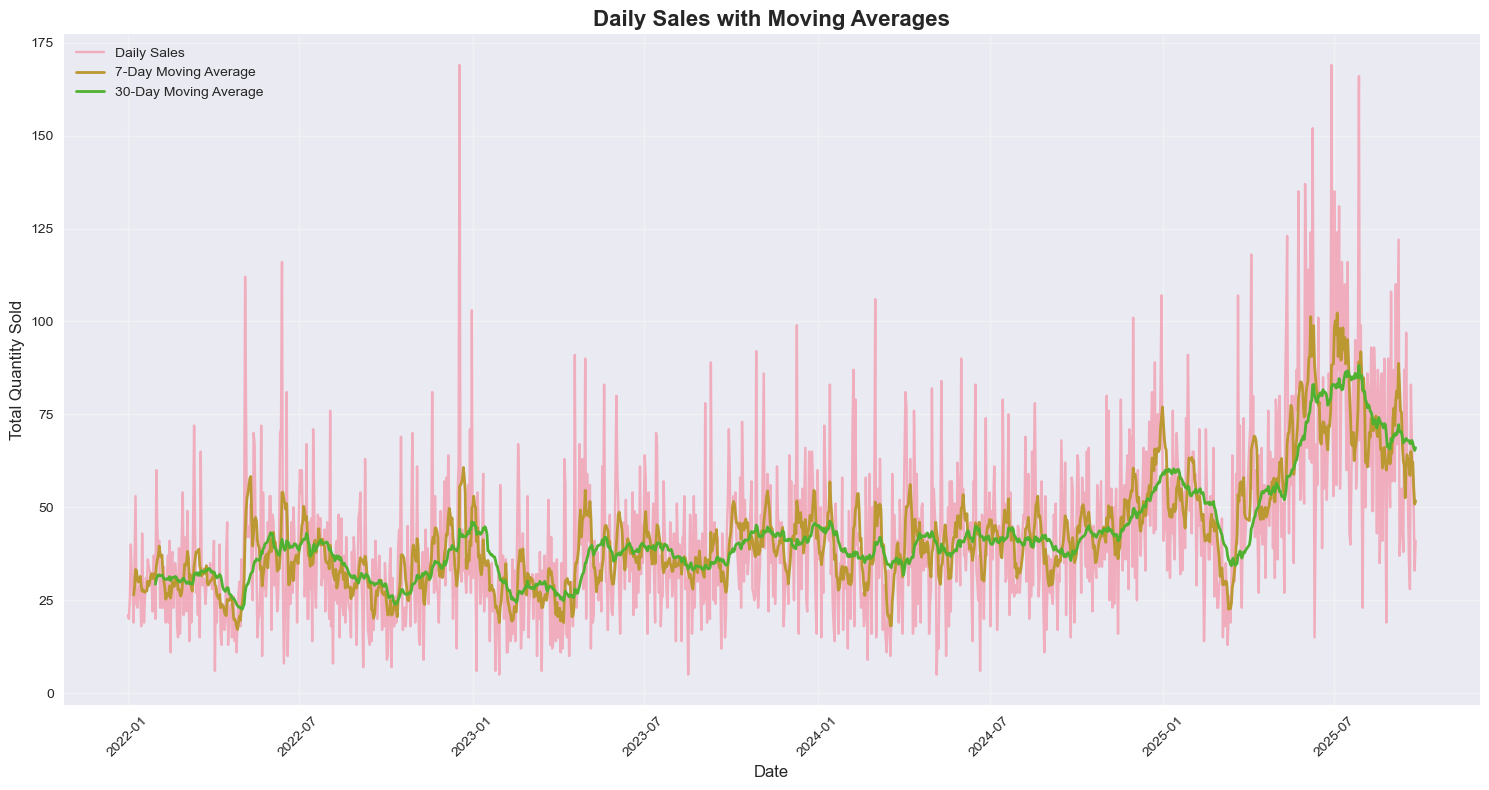

In [5]:
# Overall daily sales trend
daily_sales = df.groupby('Date')['Quantity_Sold'].sum().reset_index()

plt.figure(figsize=(15, 8))
plt.plot(daily_sales['Date'], daily_sales['Quantity_Sold'], linewidth=2)
plt.title('Daily Total Sales Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Quantity Sold', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Rolling averages
plt.figure(figsize=(15, 8))
daily_sales['7_day_ma'] = daily_sales['Quantity_Sold'].rolling(window=7).mean()
daily_sales['30_day_ma'] = daily_sales['Quantity_Sold'].rolling(window=30).mean()

plt.plot(daily_sales['Date'], daily_sales['Quantity_Sold'], alpha=0.5, label='Daily Sales')
plt.plot(daily_sales['Date'], daily_sales['7_day_ma'], linewidth=2, label='7-Day Moving Average')
plt.plot(daily_sales['Date'], daily_sales['30_day_ma'], linewidth=2, label='30-Day Moving Average')
plt.title('Daily Sales with Moving Averages', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Quantity Sold', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Trends Analysis

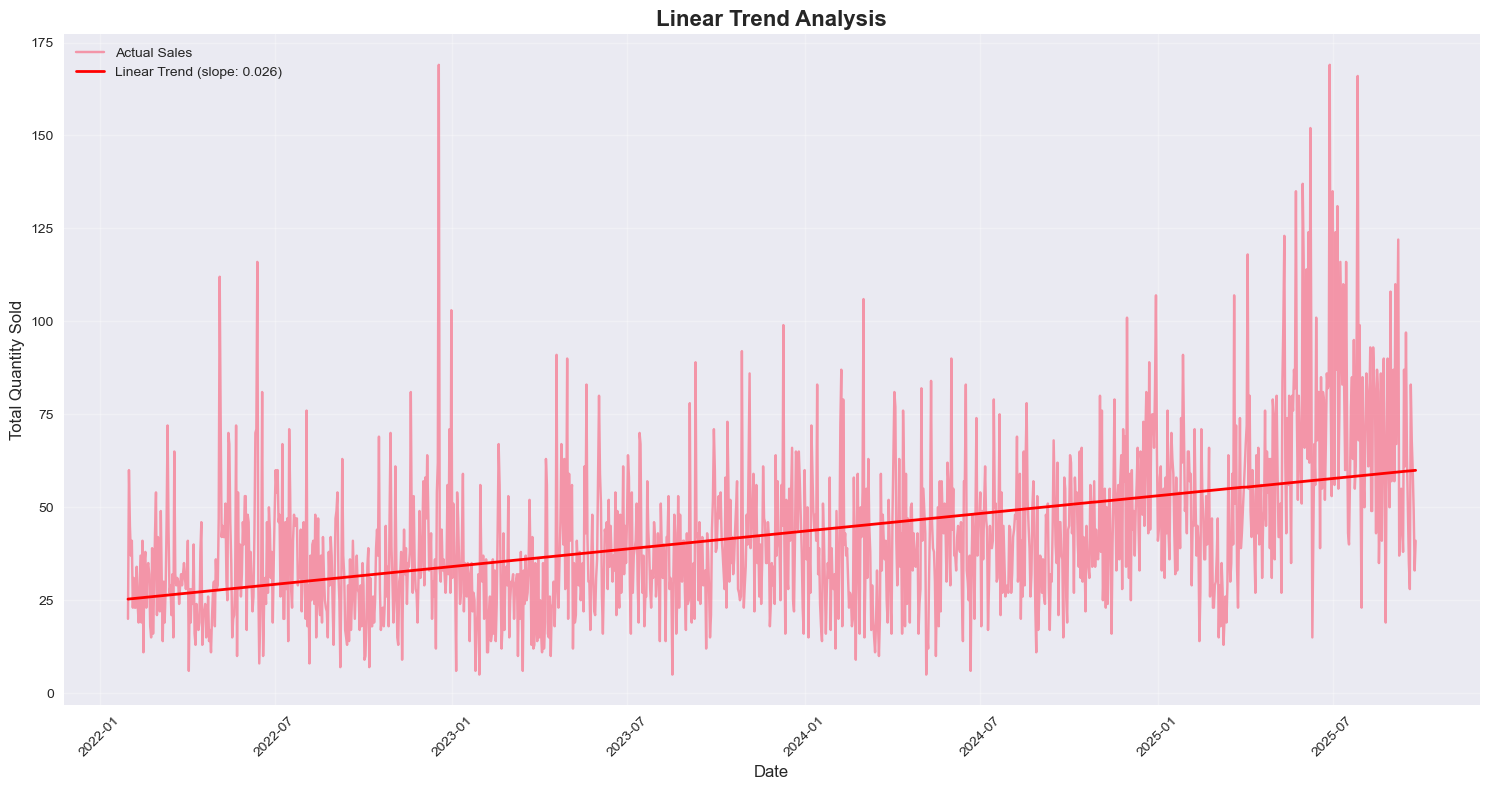

Linear Trend Analysis:
Slope: 0.0261 (units per day)
R-squared: 0.2006
P-value: 0.0000
Trend direction: Increasing


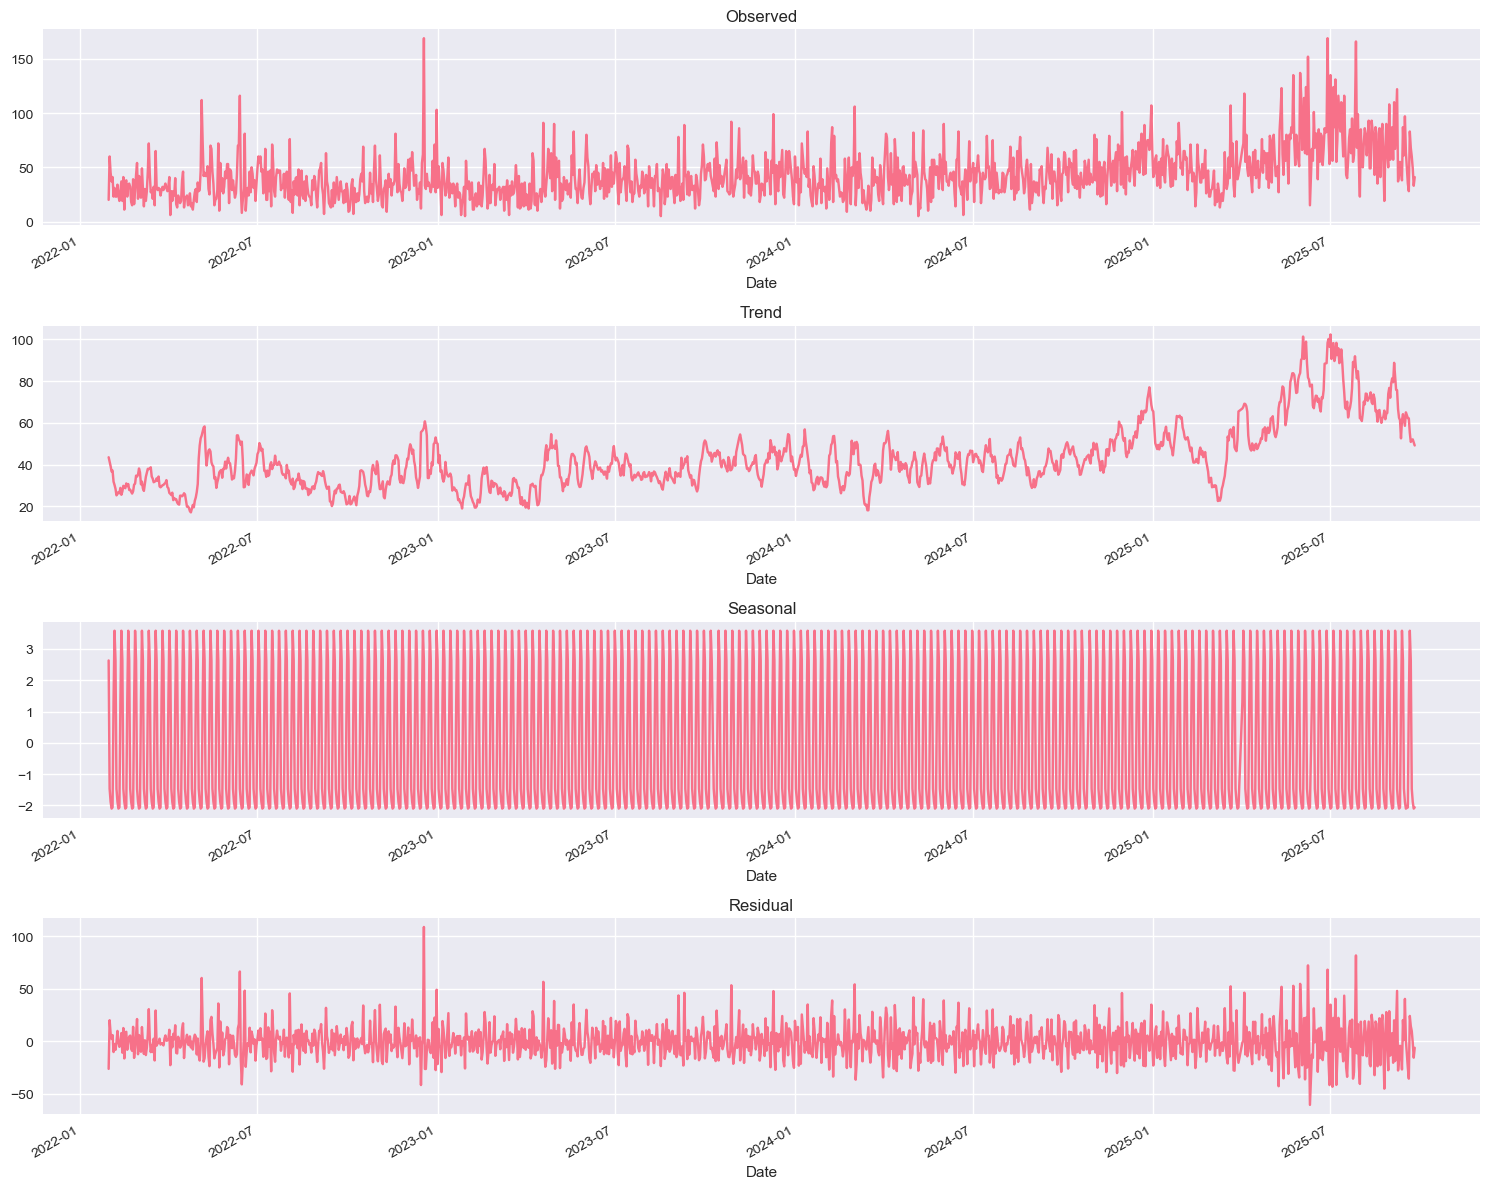

In [6]:
# Linear trend analysis
from scipy.stats import linregress

# Prepare data for trend analysis
daily_sales_clean = daily_sales.dropna()
x = np.arange(len(daily_sales_clean))
y = daily_sales_clean['Quantity_Sold'].values

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)
trend_line = slope * x + intercept

plt.figure(figsize=(15, 8))
plt.plot(daily_sales_clean['Date'], y, alpha=0.7, label='Actual Sales')
plt.plot(daily_sales_clean['Date'], trend_line, 'r-', linewidth=2, 
         label=f'Linear Trend (slope: {slope:.3f})')
plt.title('Linear Trend Analysis', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Quantity Sold', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f'Linear Trend Analysis:')
print(f'Slope: {slope:.4f} (units per day)')
print(f'R-squared: {r_value**2:.4f}')
print(f'P-value: {p_value:.4f}')
print(f'Trend direction: {"Increasing" if slope > 0 else "Decreasing" if slope < 0 else "Flat"}')

# Seasonal decomposition
try:
    # Set frequency to daily (assuming business days)
    daily_sales_ts = daily_sales_clean.set_index('Date')['Quantity_Sold']
    
    # Perform seasonal decomposition (assuming weekly seasonality)
    decomposition = seasonal_decompose(daily_sales_ts, model='additive', period=7, extrapolate_trend='freq')
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))
    
    decomposition.observed.plot(ax=ax1)
    ax1.set_title('Observed')
    
    decomposition.trend.plot(ax=ax2)
    ax2.set_title('Trend')
    
    decomposition.seasonal.plot(ax=ax3)
    ax3.set_title('Seasonal')
    
    decomposition.resid.plot(ax=ax4)
    ax4.set_title('Residual')
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f'Seasonal decomposition failed: {e}')
    print('This might be due to insufficient data or irregular time series.')

## 4. Seasonality Patterns

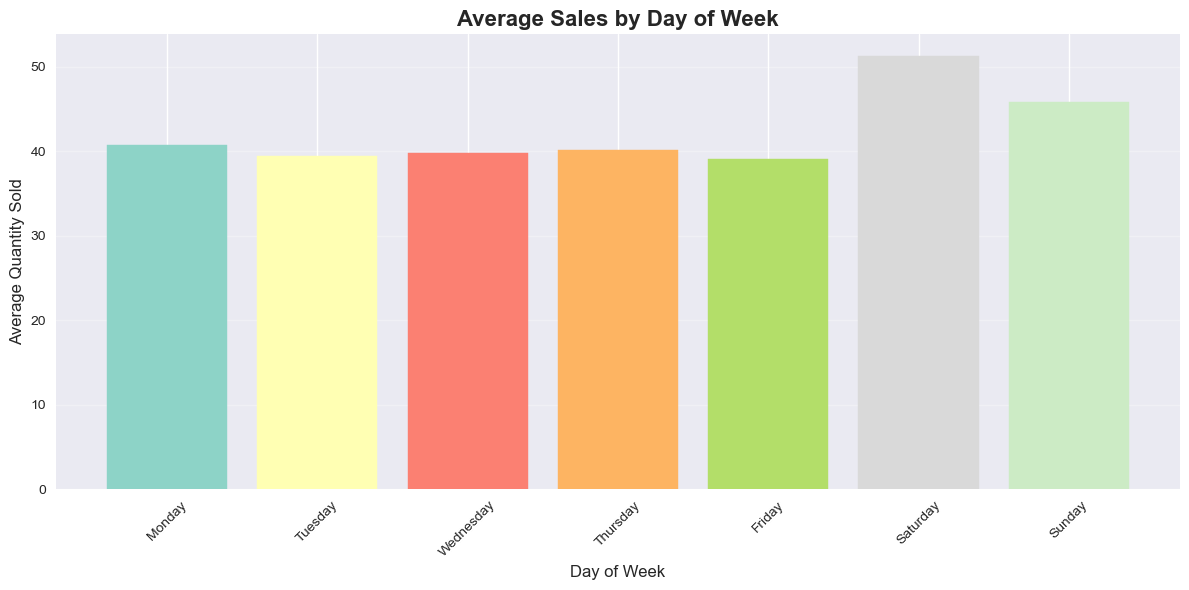

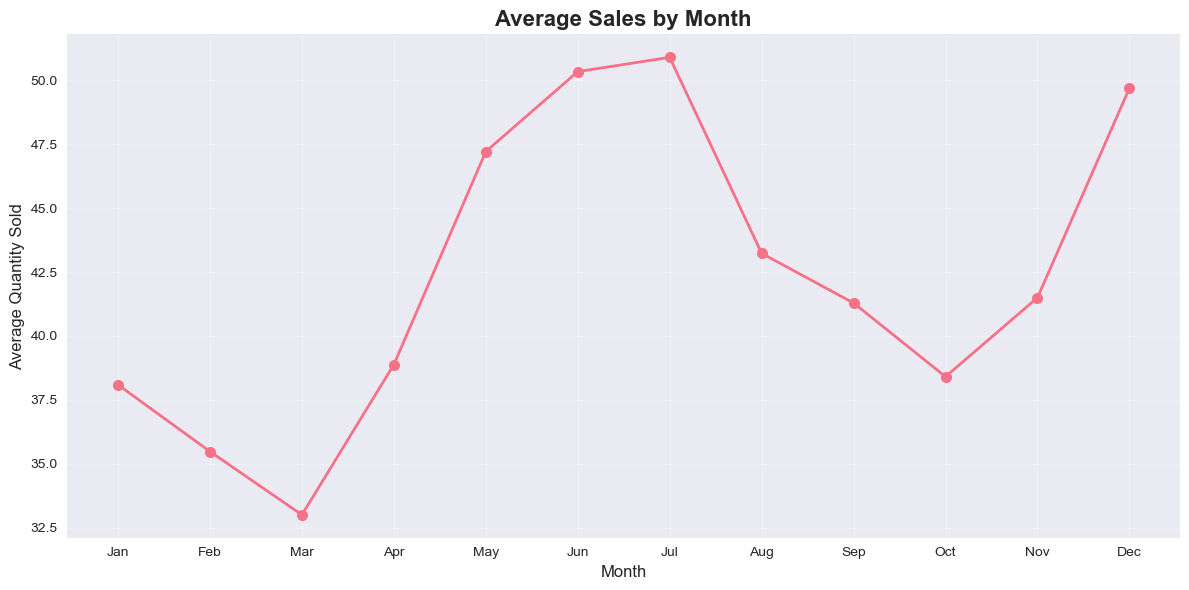

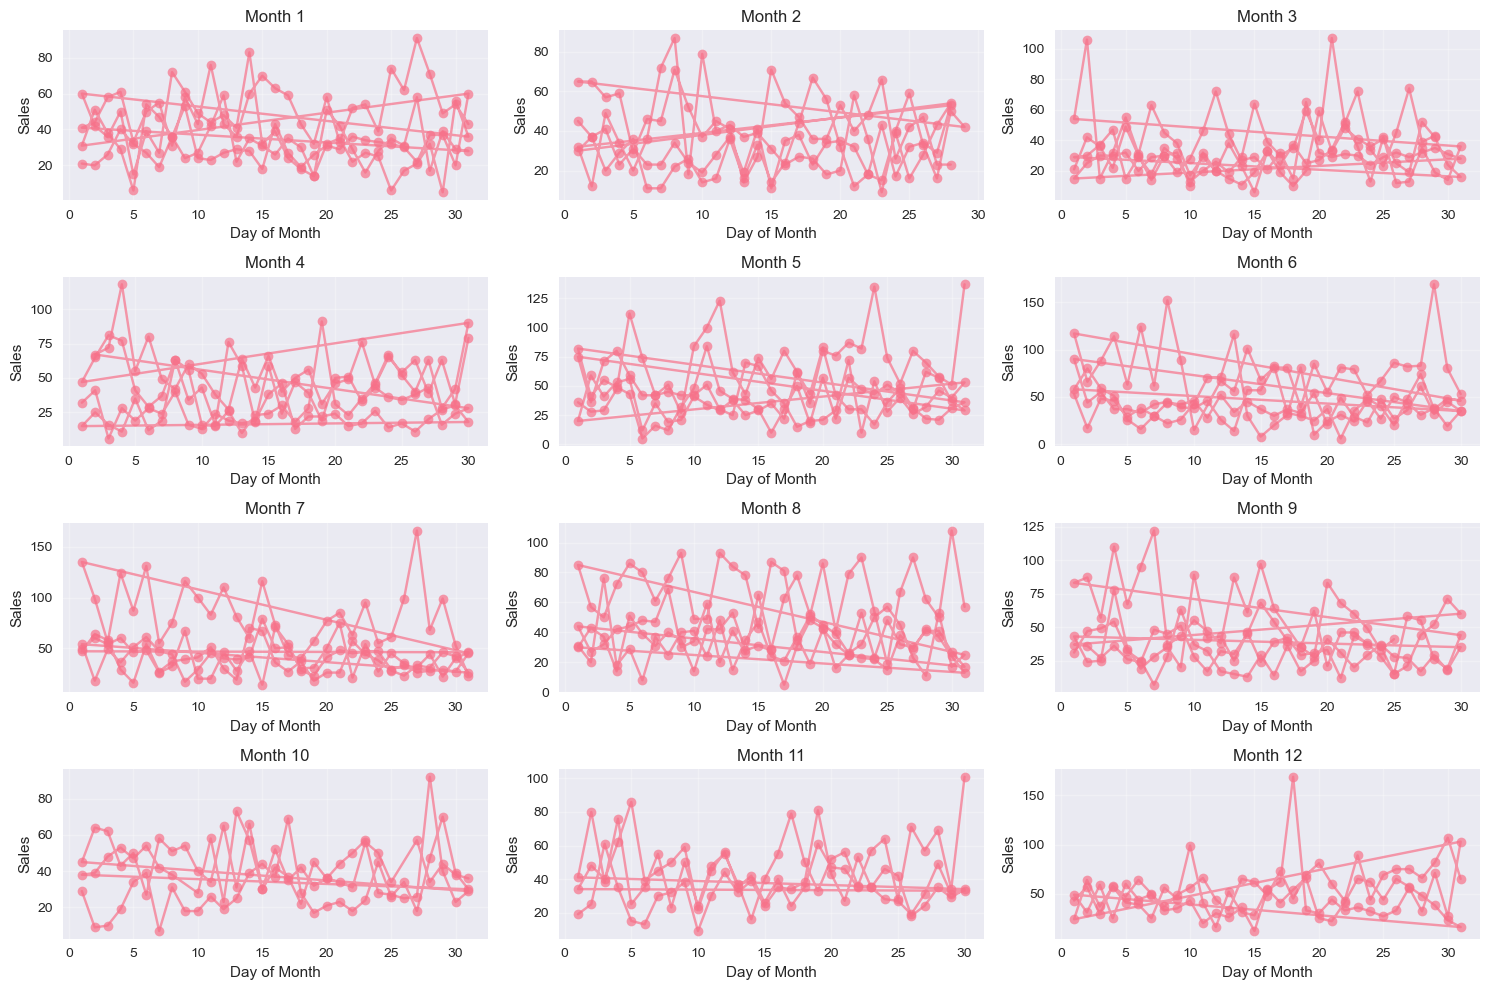

In [7]:
# Day of week analysis
daily_sales['day_of_week'] = daily_sales['Date'].dt.day_name()
daily_sales['month'] = daily_sales['Date'].dt.month
daily_sales['year'] = daily_sales['Date'].dt.year

# Average sales by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_avg = daily_sales.groupby('day_of_week')['Quantity_Sold'].mean().reindex(day_order)

plt.figure(figsize=(12, 6))
bars = plt.bar(day_avg.index, day_avg.values)
plt.title('Average Sales by Day of Week', fontsize=16, fontweight='bold')
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Average Quantity Sold', fontsize=12)
plt.xticks(rotation=45)

# Color the bars
for i, bar in enumerate(bars):
    bar.set_color(plt.cm.Set3(i / len(day_avg)))

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Monthly patterns
monthly_avg = daily_sales.groupby('month')['Quantity_Sold'].mean()

plt.figure(figsize=(12, 6))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o', linewidth=2, markersize=8)
plt.title('Average Sales by Month', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Quantity Sold', fontsize=12)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Seasonal subseries plot (by month)
plt.figure(figsize=(15, 10))
for month in range(1, 13):
    month_data = daily_sales[daily_sales['month'] == month]
    if not month_data.empty:
        plt.subplot(4, 3, month)
        plt.plot(month_data['Date'].dt.day, month_data['Quantity_Sold'], marker='o', alpha=0.7)
        plt.title(f'Month {month}')
        plt.xlabel('Day of Month')
        plt.ylabel('Sales')
        plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Stationarity Assessment


Stationarity Tests for Daily Total Sales:
--------------------------------------------------
ADF Test:
  Test Statistic: -3.4272
  p-value: 0.0101
  Critical Values:
    1%: -3.4352
    5%: -2.8637
    10%: -2.5679
  Stationary: Yes

KPSS Test:
  Test Statistic: 3.9018
  p-value: 0.0100
  Critical Values:
    10%: 0.3470
    5%: 0.4630
    2.5%: 0.5740
    1%: 0.7390
  Stationary: No

Stationarity Tests for Differenced Daily Sales (1st difference):
--------------------------------------------------
ADF Test:
  Test Statistic: -16.5715
  p-value: 0.0000
  Critical Values:
    1%: -3.4352
    5%: -2.8637
    10%: -2.5679
  Stationary: Yes

KPSS Test:
  Test Statistic: 0.0584
  p-value: 0.1000
  Critical Values:
    10%: 0.3470
    5%: 0.4630
    2.5%: 0.5740
    1%: 0.7390
  Stationary: Yes


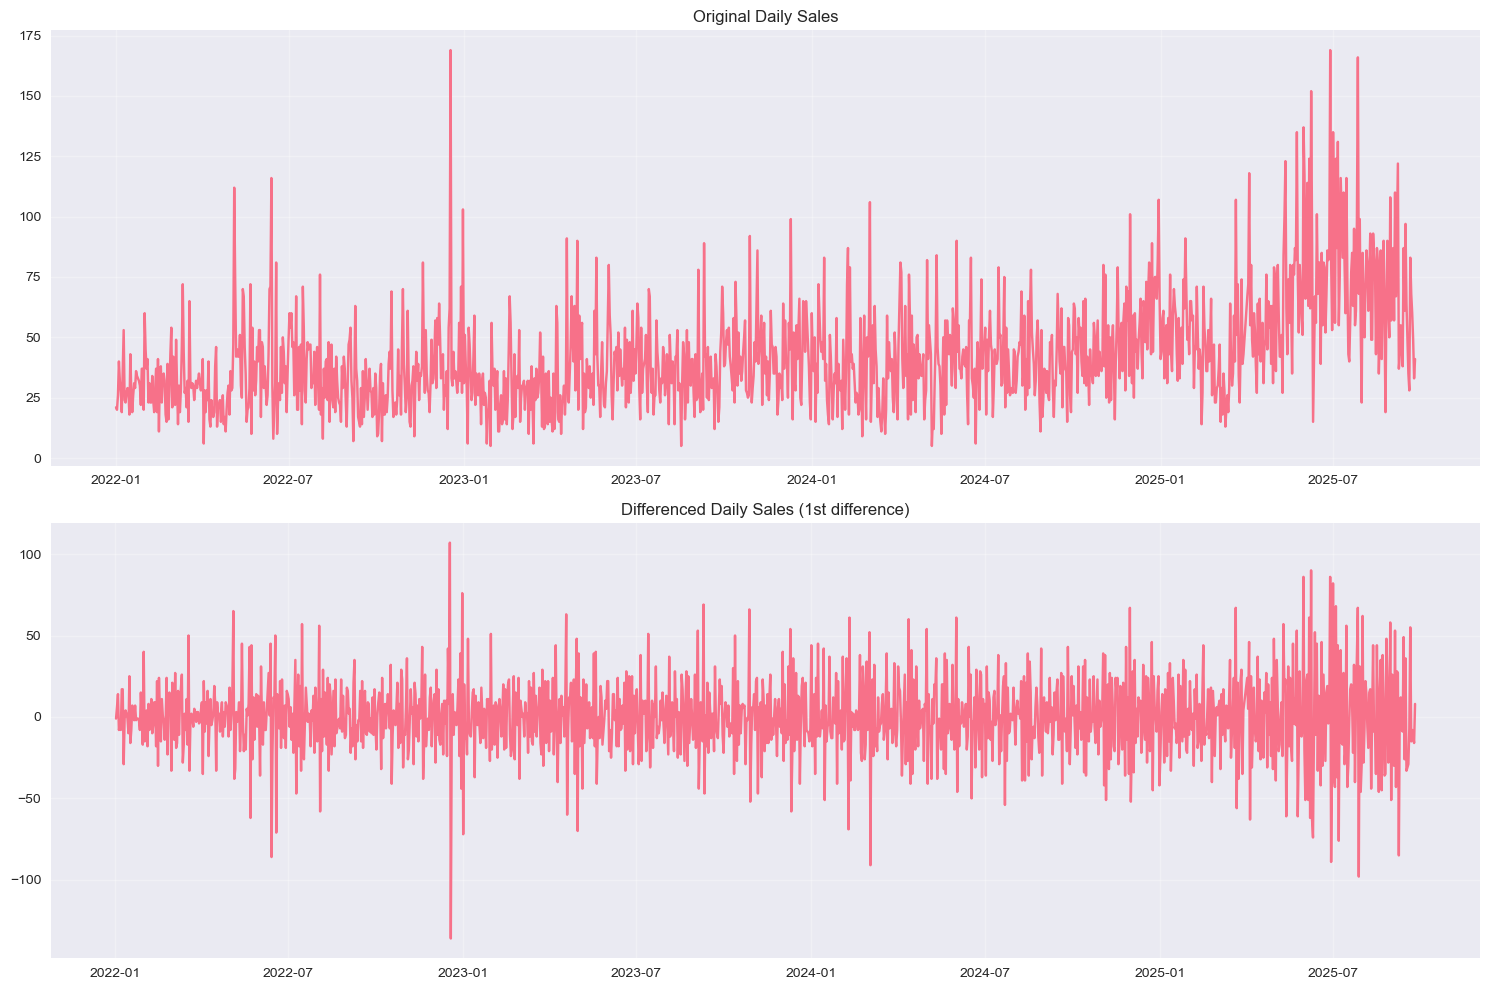

In [8]:
# Stationarity tests
def test_stationarity(timeseries, title):
    """Test stationarity using ADF and KPSS tests"""
    print(f'\nStationarity Tests for {title}:')
    print('-' * 50)
    
    adf_p_value = None
    kpss_p_value = None
    
    # ADF Test
    try:
        adf_result = adfuller(timeseries.dropna(), autolag='AIC')
        adf_p_value = adf_result[1]
        print('ADF Test:')
        print(f'  Test Statistic: {adf_result[0]:.4f}')
        print(f'  p-value: {adf_p_value:.4f}')
        print(f'  Critical Values:')
        for key, value in adf_result[4].items():
            print(f'    {key}: {value:.4f}')
        print(f'  Stationary: {"Yes" if adf_p_value < 0.05 else "No"}')
    except:
        print('ADF Test failed')
    
    # KPSS Test
    try:
        kpss_result = kpss(timeseries.dropna(), regression='c', nlags='auto')
        kpss_p_value = kpss_result[1]
        print('\nKPSS Test:')
        print(f'  Test Statistic: {kpss_result[0]:.4f}')
        print(f'  p-value: {kpss_p_value:.4f}')
        print(f'  Critical Values:')
        for key, value in kpss_result[3].items():
            print(f'    {key}: {value:.4f}')
        print(f'  Stationary: {"Yes" if kpss_p_value > 0.05 else "No"}')
    except:
        print('KPSS Test failed')
    
    return adf_p_value, kpss_p_value

# Test stationarity on daily sales
adf_p_value_original, kpss_p_value_original = test_stationarity(daily_sales['Quantity_Sold'], 'Daily Total Sales')

# Test on differenced series
daily_sales_diff = daily_sales['Quantity_Sold'].diff().dropna()
adf_p_value_diff, kpss_p_value_diff = test_stationarity(daily_sales_diff, 'Differenced Daily Sales (1st difference)')

# Plot original vs differenced
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

ax1.plot(daily_sales['Date'], daily_sales['Quantity_Sold'])
ax1.set_title('Original Daily Sales')
ax1.grid(True, alpha=0.3)

ax2.plot(daily_sales['Date'].iloc[1:], daily_sales_diff)
ax2.set_title('Differenced Daily Sales (1st difference)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Cyclical Patterns

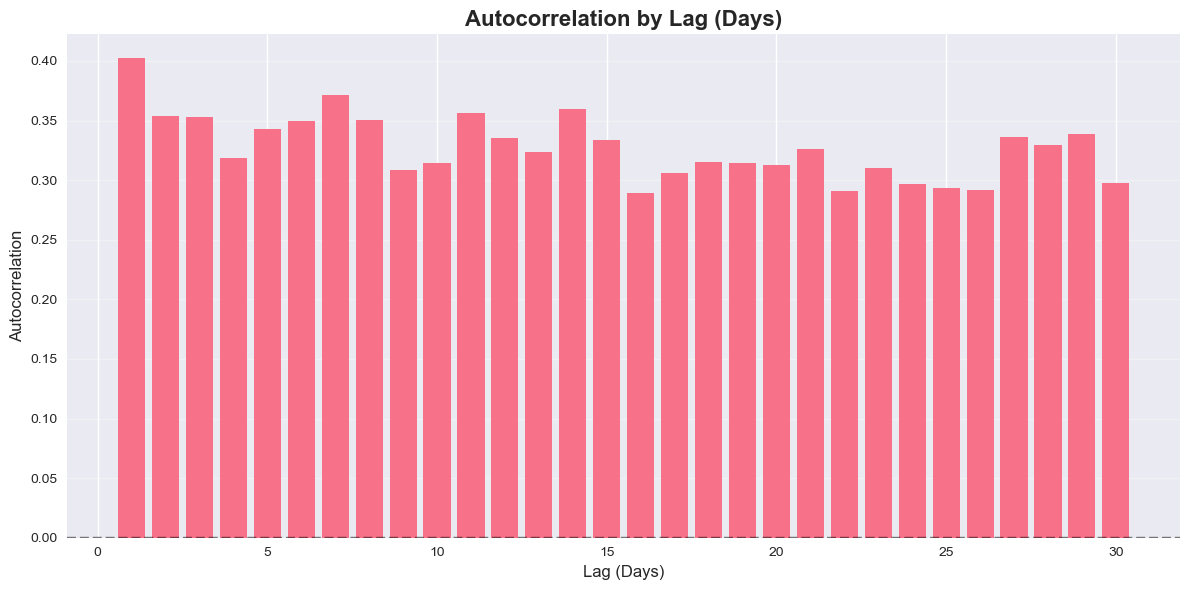


Potentially significant lags (correlation > 0.2): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


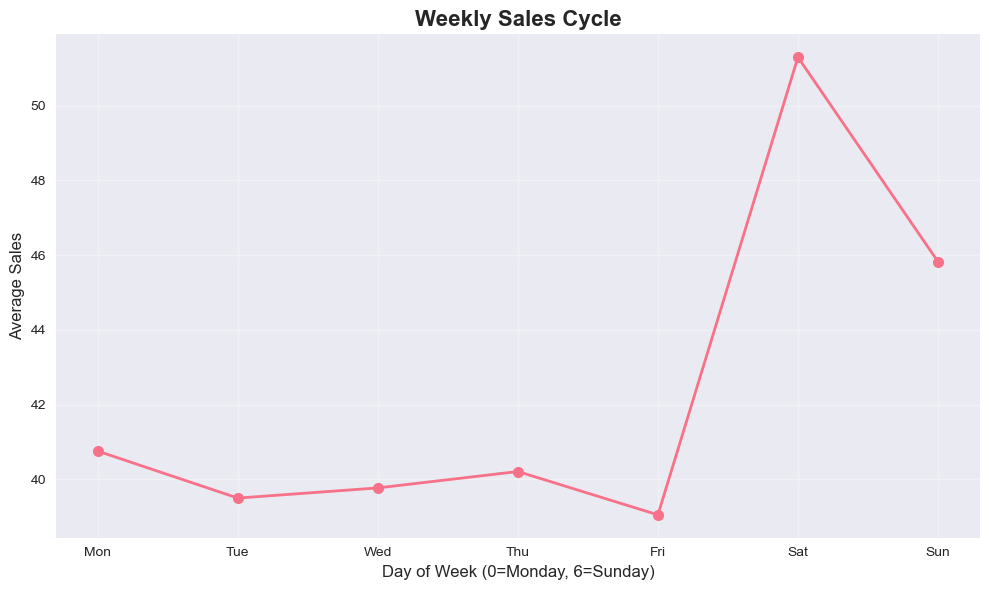

In [9]:
# Analyze cyclical patterns (longer-term cycles)
# Using autocorrelation to identify potential cycles

# Calculate autocorrelation for different lags
lags = range(1, 31)  # Check up to 30 days
autocorr = [daily_sales['Quantity_Sold'].autocorr(lag=lag) for lag in lags]

plt.figure(figsize=(12, 6))
plt.bar(lags, autocorr)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title('Autocorrelation by Lag (Days)', fontsize=16, fontweight='bold')
plt.xlabel('Lag (Days)', fontsize=12)
plt.ylabel('Autocorrelation', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Identify potential cycles
significant_lags = [lag for lag, corr in zip(lags, autocorr) if abs(corr) > 0.2]
print(f'\nPotentially significant lags (correlation > 0.2): {significant_lags}')

# Weekly cycle analysis
weekly_avg = daily_sales.groupby(daily_sales['Date'].dt.weekday)['Quantity_Sold'].mean()

plt.figure(figsize=(10, 6))
plt.plot(weekly_avg.index, weekly_avg.values, marker='o', linewidth=2, markersize=8)
plt.title('Weekly Sales Cycle', fontsize=16, fontweight='bold')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)', fontsize=12)
plt.ylabel('Average Sales', fontsize=12)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Outlier Detection

Outlier Detection Results:
Total data points: 1357
Z-score outliers (threshold=3): 21
IQR outliers (multiplier=1.5): 42


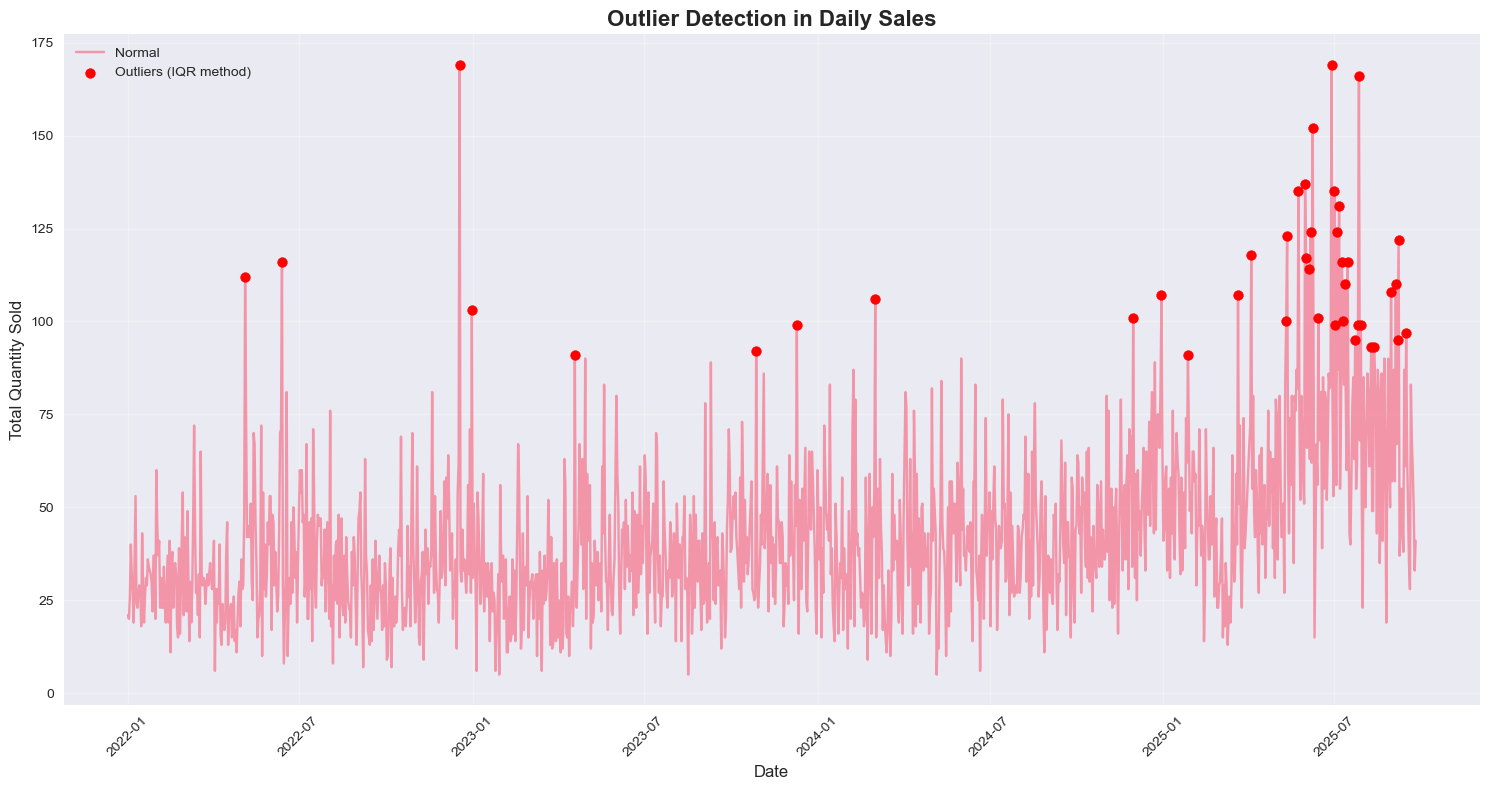

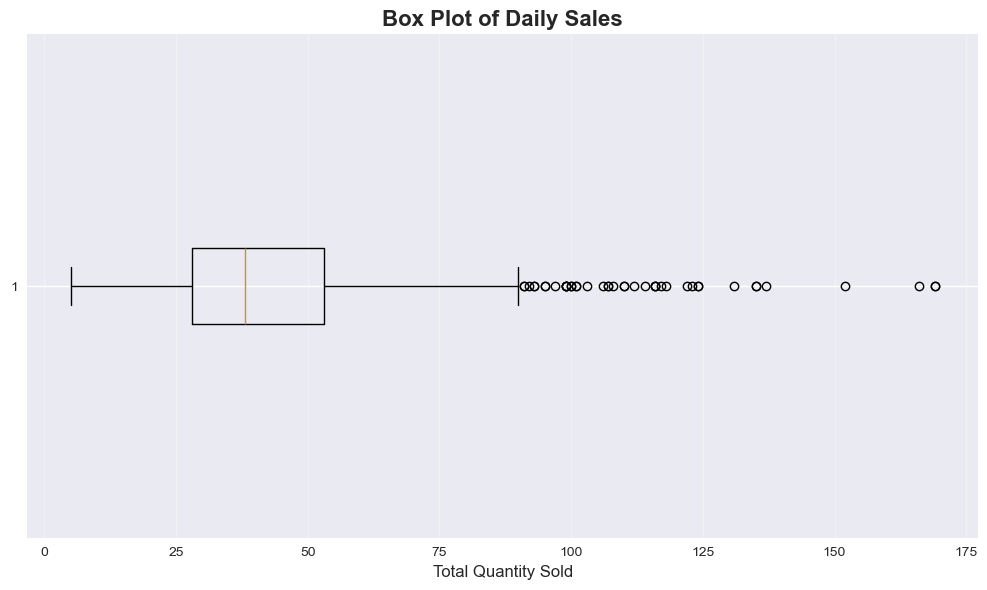


Outlier Details (IQR method):
           Date  Quantity_Sold  Deviation_from_Mean
351  2022-12-18          169.0           126.654385
1268 2025-06-28          169.0           126.654385
1297 2025-07-27          166.0           123.654385
1249 2025-06-08          152.0           109.654385
1241 2025-05-31          137.0            94.654385
1234 2025-05-24          135.0            92.654385
1271 2025-07-01          135.0            92.654385
1276 2025-07-06          131.0            88.654385
1247 2025-06-06          124.0            81.654385
1274 2025-07-04          124.0            81.654385
1222 2025-05-12          123.0            80.654385
1339 2025-09-07          122.0            79.654385
1184 2025-04-04          118.0            75.654385
1242 2025-06-01          117.0            74.654385
1285 2025-07-15          116.0            73.654385
163  2022-06-13          116.0            73.654385
1279 2025-07-09          116.0            73.654385
1245 2025-06-04          114.0   

In [10]:
# Outlier detection using statistical methods
def detect_outliers_zscore(data, threshold=3):
    """Detect outliers using Z-score method"""
    z_scores = np.abs(stats.zscore(data))
    return z_scores > threshold

def detect_outliers_iqr(data, multiplier=1.5):
    """Detect outliers using IQR method"""
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    return (data < lower_bound) | (data > upper_bound)

# Detect outliers
sales_data = daily_sales['Quantity_Sold'].dropna()
zscore_outliers = detect_outliers_zscore(sales_data)
iqr_outliers = detect_outliers_iqr(sales_data)

print('Outlier Detection Results:')
print(f'Total data points: {len(sales_data)}')
print(f'Z-score outliers (threshold=3): {zscore_outliers.sum()}')
print(f'IQR outliers (multiplier=1.5): {iqr_outliers.sum()}')

# Visualize outliers
plt.figure(figsize=(15, 8))
plt.plot(daily_sales['Date'], daily_sales['Quantity_Sold'], alpha=0.7, label='Normal')

# Highlight outliers
outlier_dates = daily_sales['Date'][iqr_outliers]
outlier_values = daily_sales['Quantity_Sold'][iqr_outliers]
plt.scatter(outlier_dates, outlier_values, color='red', s=50, label='Outliers (IQR method)', zorder=5)

plt.title('Outlier Detection in Daily Sales', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Quantity Sold', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Box plot for outlier visualization
plt.figure(figsize=(10, 6))
plt.boxplot(sales_data, vert=False)
plt.title('Box Plot of Daily Sales', fontsize=16, fontweight='bold')
plt.xlabel('Total Quantity Sold', fontsize=12)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Show outlier details
if iqr_outliers.sum() > 0:
    print('\nOutlier Details (IQR method):')
    outliers_df = daily_sales[iqr_outliers][['Date', 'Quantity_Sold']].copy()
    outliers_df['Deviation_from_Mean'] = outliers_df['Quantity_Sold'] - sales_data.mean()
    print(outliers_df.sort_values('Quantity_Sold', ascending=False))

## 8. Autocorrelation Analysis (ACF/PACF)

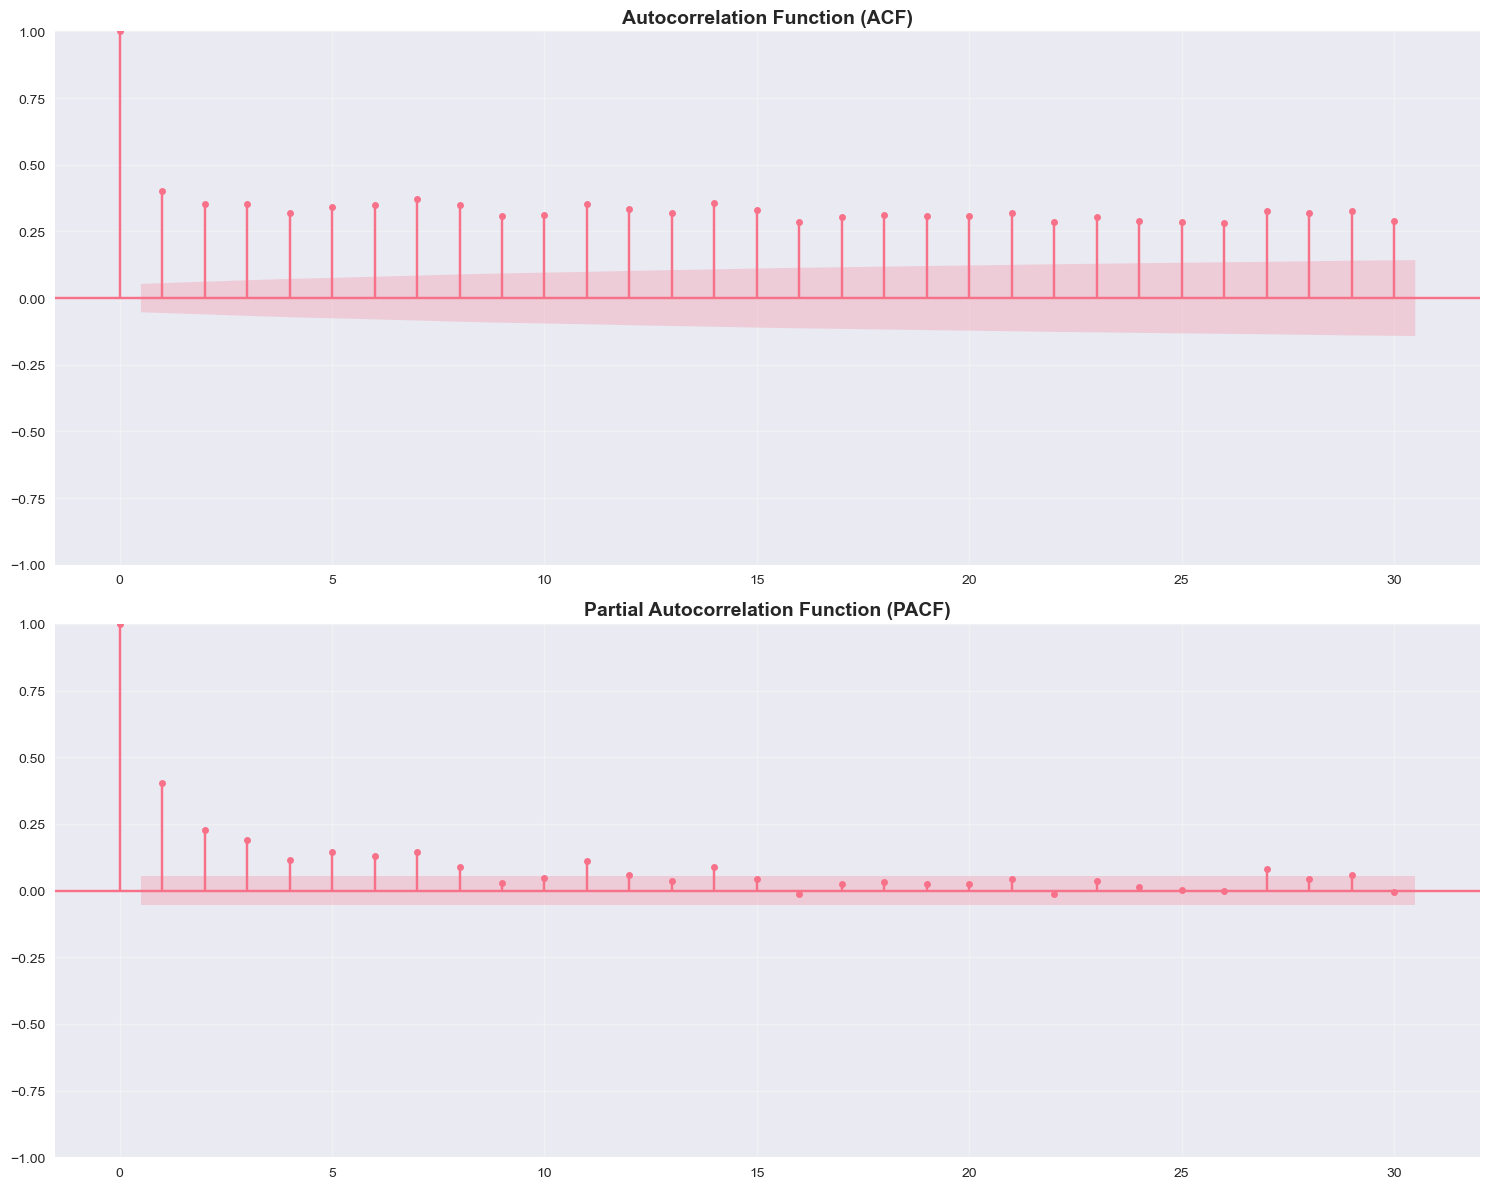

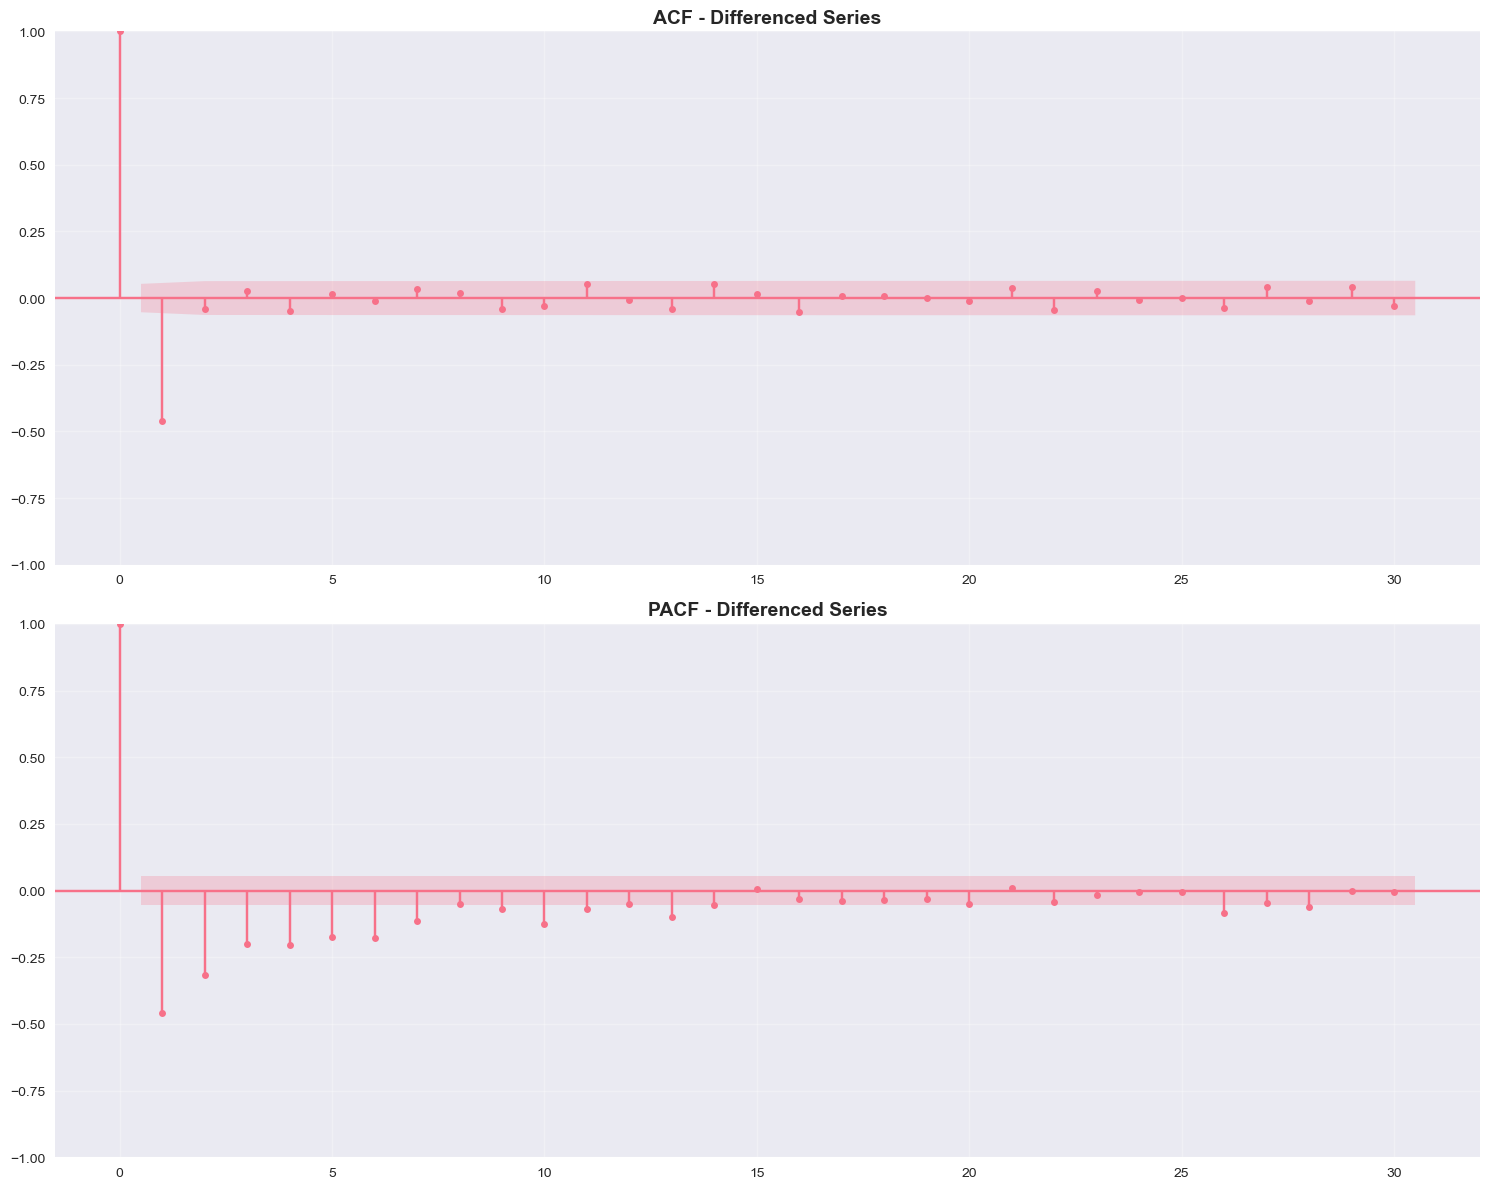

In [11]:
# ACF and PACF plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# ACF plot
plot_acf(daily_sales['Quantity_Sold'].dropna(), lags=30, ax=ax1, alpha=0.05)
ax1.set_title('Autocorrelation Function (ACF)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# PACF plot
plot_pacf(daily_sales['Quantity_Sold'].dropna(), lags=30, ax=ax2, alpha=0.05)
ax2.set_title('Partial Autocorrelation Function (PACF)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ACF and PACF for differenced series
if len(daily_sales_diff) > 30:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # ACF plot for differenced series
    plot_acf(daily_sales_diff, lags=30, ax=ax1, alpha=0.05)
    ax1.set_title('ACF - Differenced Series', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # PACF plot for differenced series
    plot_pacf(daily_sales_diff, lags=30, ax=ax2, alpha=0.05)
    ax2.set_title('PACF - Differenced Series', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 9. Item-Specific Analysis

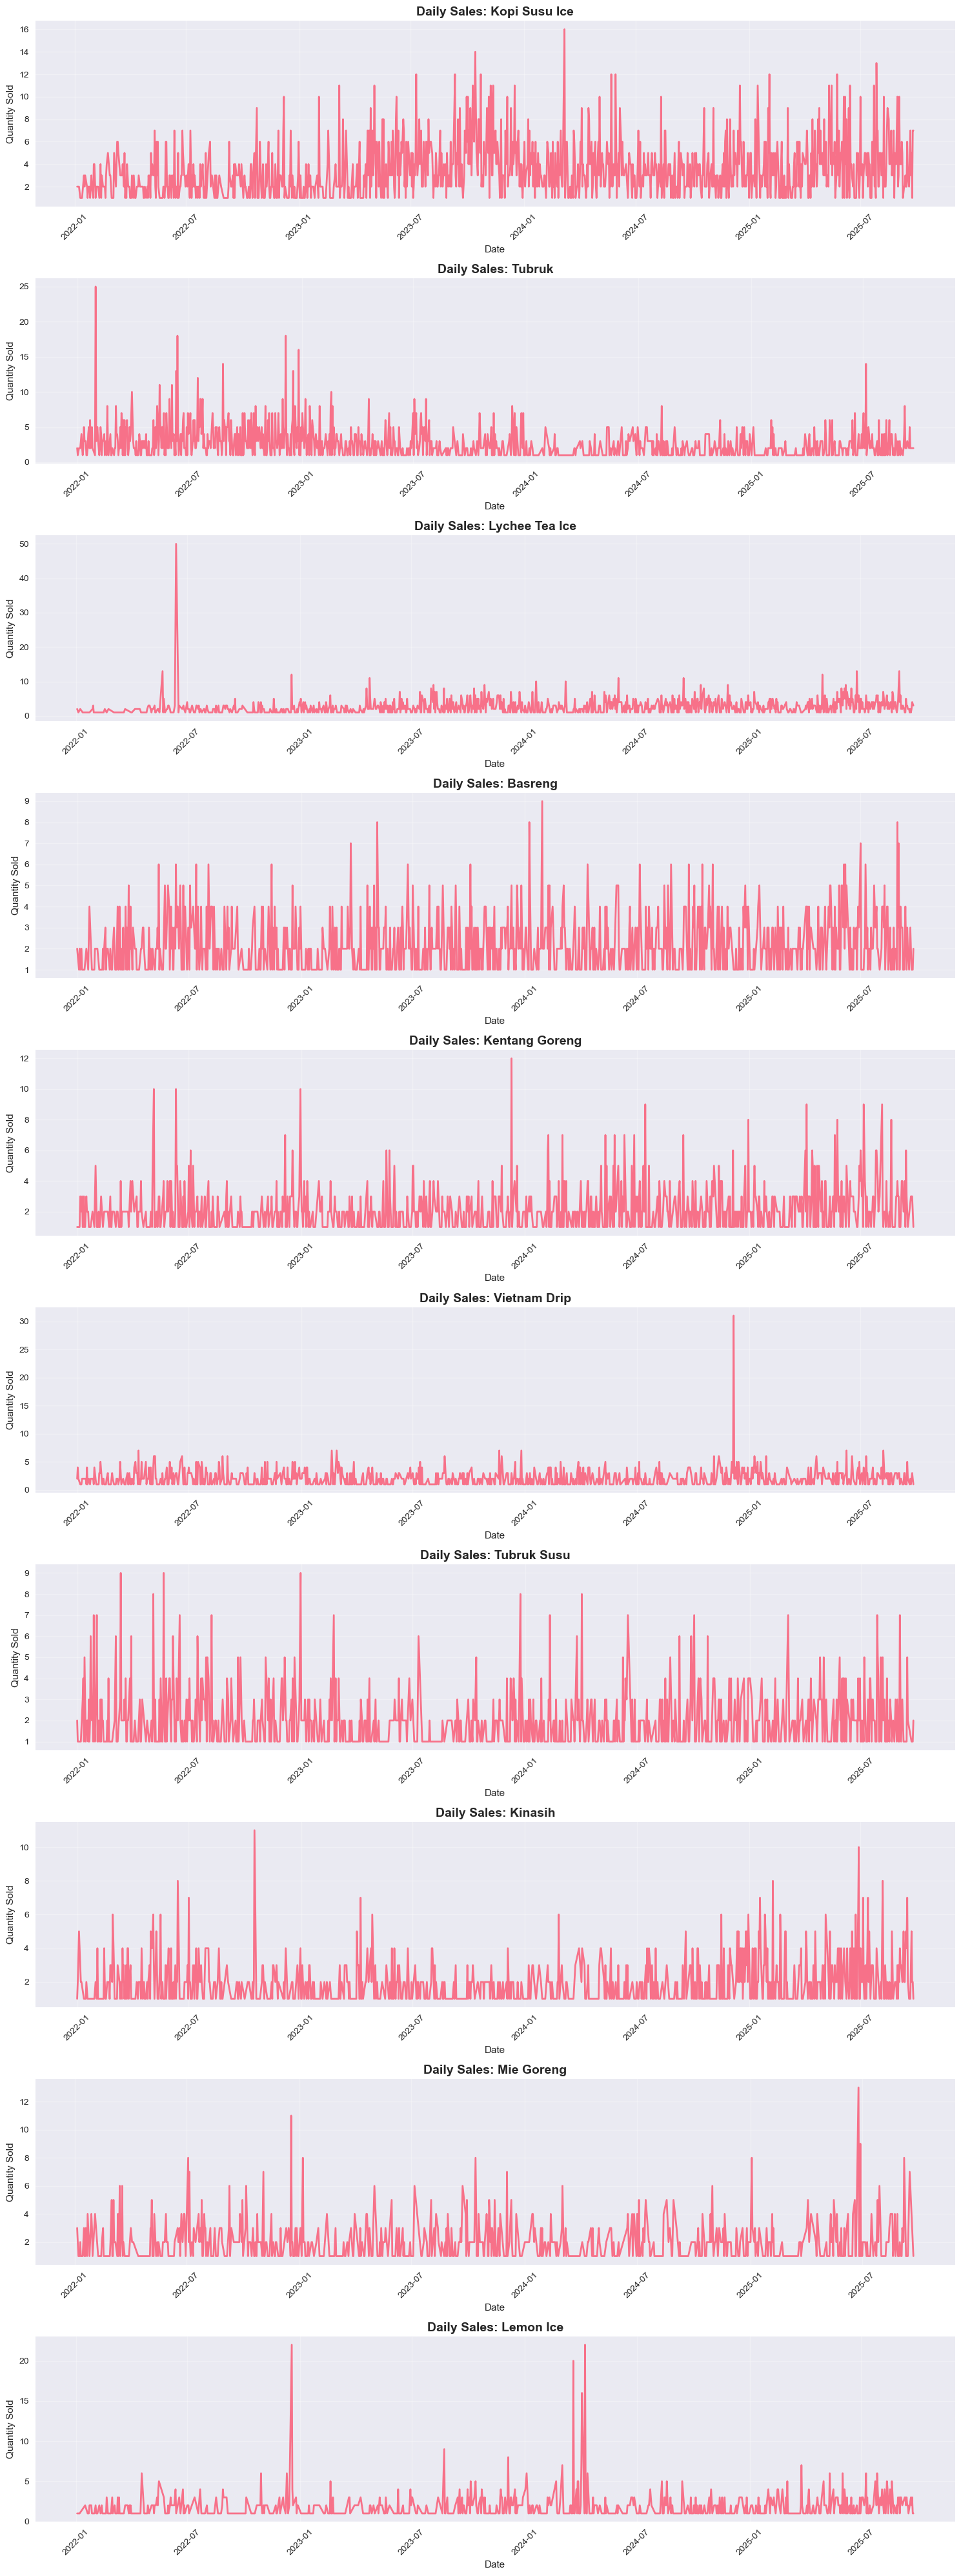

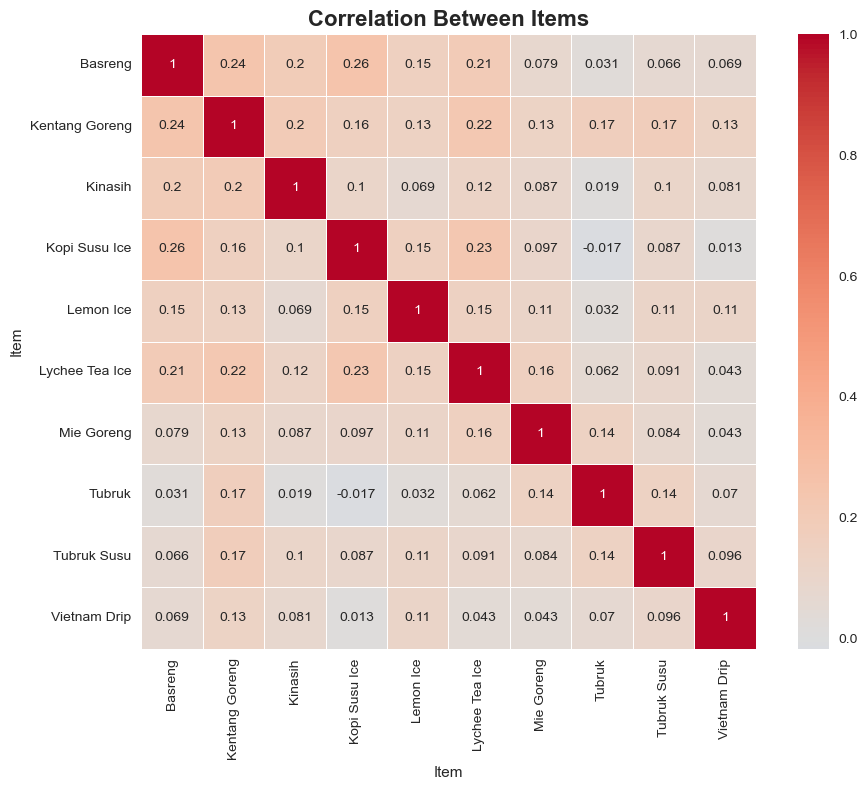

In [12]:
# Analyze top-selling items individually
top_5_items = top_items.head(100).index.tolist()

fig, axes = plt.subplots(len(top_5_items), 1, figsize=(15, 4*len(top_5_items)))
if len(top_5_items) == 1:
    axes = [axes]

for i, item in enumerate(top_5_items):
    item_data = df[df['Item'] == item].copy()
    item_data = item_data.sort_values('Date')
    
    axes[i].plot(item_data['Date'], item_data['Quantity_Sold'], linewidth=2)
    axes[i].set_title(f'Daily Sales: {item}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Quantity Sold')
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Correlation between top items
top_items_data = df[df['Item'].isin(top_5_items)].pivot(index='Date', columns='Item', values='Quantity_Sold').fillna(0)

plt.figure(figsize=(10, 8))
correlation_matrix = top_items_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Between Items', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 10. Summary and Key Findings

In [13]:
print('=' * 80)
print('EDA SUMMARY - DAILY ITEM SALES ANALYSIS')
print('=' * 80)

print(f'\nData Overview:')
print(f'- Total records: {len(df):,}')
print(f'- Date range: {df["Date"].min().date()} to {df["Date"].max().date()}')
print(f'- Unique items: {df["Item"].nunique()}')
print(f'- Total sales quantity: {df["Quantity_Sold"].sum():,.0f}')

print(f'\nTop 5 Items by Total Sales:')
for i, (item, qty) in enumerate(top_items.head(5).items(), 1):
    print(f'{i}. {item}: {qty:,.0f} units')

print(f'\nDaily Sales Statistics:')
daily_stats = daily_totals.describe()
print(f'- Mean daily sales: {daily_stats["mean"]:.1f} units')
print(f'- Median daily sales: {daily_stats["50%"]:.1f} units')
print(f'- Min daily sales: {daily_stats["min"]:.1f} units')
print(f'- Max daily sales: {daily_stats["max"]:.1f} units')
print(f'- Standard deviation: {daily_stats["std"]:.1f} units')

print(f'\nOutlier Analysis:')
print(f'- Outliers detected (IQR method): {iqr_outliers.sum()}')
print(f'- Percentage of outlier days: {(iqr_outliers.sum() / len(sales_data) * 100):.1f}%')

print(f'\nKey Patterns Identified:')
print(f'- Trend: {"Increasing" if slope > 0 else "Decreasing" if slope < 0 else "Stable"}')
print(f'- Weekly seasonality: {"Present" if day_avg.std() > day_avg.mean() * 0.1 else "Weak"}')
print(f'- Stationarity: {"Non-stationary" if adf_p_value_original and adf_p_value_original > 0.05 else "Stationary"} (ADF test)')

print('\nRecommendations for Modeling:')
print('- Consider differencing for stationarity if using ARIMA-type models')
print('- Include day-of-week effects in forecasting models')
print('- Investigate outlier causes for improved predictions')
print('- Consider hierarchical forecasting for multiple items')

print('\n' + '=' * 80)

EDA SUMMARY - DAILY ITEM SALES ANALYSIS

Data Overview:
- Total records: 31,563
- Date range: 2022-01-01 to 2025-09-25
- Unique items: 78
- Total sales quantity: 57,463

Top 5 Items by Total Sales:
1. Kopi Susu Ice: 4,185 units
2. Tubruk: 2,799 units
3. Lychee Tea Ice: 2,787 units
4. Basreng: 2,172 units
5. Kentang Goreng: 2,093 units

Daily Sales Statistics:
- Mean daily sales: 42.3 units
- Median daily sales: 38.0 units
- Min daily sales: 5.0 units
- Max daily sales: 169.0 units
- Standard deviation: 22.2 units

Outlier Analysis:
- Outliers detected (IQR method): 42
- Percentage of outlier days: 3.1%

Key Patterns Identified:
- Trend: Increasing
- Weekly seasonality: Present
- Stationarity: Stationary (ADF test)

Recommendations for Modeling:
- Consider differencing for stationarity if using ARIMA-type models
- Include day-of-week effects in forecasting models
- Investigate outlier causes for improved predictions
- Consider hierarchical forecasting for multiple items

